In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch, torch.nn as nn
from torch.utils.data import DataLoader, random_split 
from torchvision.transforms import Normalize, Lambda

import sys, os
sys.path.append(os.path.join(os.path.dirname("./"), '..'))

from utils.Training import Train_MAE
from utils.CustomDataset import CustomDatasetSelfSupervised
from Models.MaskedAutoEncoders import MaskedAutoEncoder

/Users/mandakausthubh/anaconda3/envs/ViT/lib/python3.12/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/Users/mandakausthubh/anaconda3/envs/ViT/lib/python3.12/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <367D4265-B20F-34BD-94EB-4F3EE47C385B> /Users/mandakausthubh/anaconda3/envs/ViT/lib/python3.12/site-packages/torchvision/image.so
  Reason: tried: '/Users/mandakausthubh/anaconda3/envs/ViT/lib/python3.12/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/mandakausthubh/anaconda3/envs/ViT/lib/python3.12/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/mandakausthubh/anaconda3/envs/ViT/lib/python3.12/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/mandakausthubh/anaconda3/envs/ViT/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `torchvision.io`, you can ignore this

In [2]:
# Loading the data

Data = []
LabelToId = {'no_sub': 0, 'cmd': 1, 'axion':2}

# Walking through the train directory and loading the data
for root, dirs, files in os.walk("../dataset/DatasetTask6A/no_sub"):
    for file in files:
        if file.endswith(".npy"):
            Data.append(np.expand_dims(np.load(os.path.join(root, file)), axis=0))

# Transform = Normalize(mean=[0.5], std=[0.5])
class MinMaxNormalize(object):
    """Normalizes a tensor to [0, 1] range using min and max of the tensor."""
    def __init__(self, min_val=None, max_val=None):
        """
        Args:
            min_val (float, optional): Fixed min value. If None, computed from input.
            max_val (float, optional): Fixed max value. If None, computed from input.
        """
        self.min_val = min_val
        self.max_val = max_val

    def __call__(self, tensor):
        """
        Args:
            tensor (torch.Tensor): Input tensor of shape (C, H, W) or (H, W)
        Returns:
            torch.Tensor: Normalized tensor in [0, 1]
        """
        if self.min_val is None or self.max_val is None:
            min_val = tensor.min()
            max_val = tensor.max()
        else:
            min_val = self.min_val
            max_val = self.max_val

        # Avoid division by zero
        if max_val == min_val:
            return torch.zeros_like(tensor) if min_val == 0 else torch.ones_like(tensor)
        
        return (tensor - min_val) / (max_val - min_val)

# Data = Data[:100]
Data = torch.Tensor(Data).to(dtype=torch.float32)
Dataset = CustomDatasetSelfSupervised(Data, transform=MinMaxNormalize())
TrainLen = int(0.9 * len(Dataset))
ValLen = len(Dataset) - TrainLen

TrainDataset, ValidationDataset = random_split(Dataset, lengths=[TrainLen, ValLen])
TrainLoader = DataLoader(TrainDataset, batch_size=128, shuffle=True)
ValidationLoader = DataLoader(ValidationDataset, batch_size=128, shuffle=True)

/var/folders/mh/r3bzvtd11h105hlbbgl239940000gn/T/ipykernel_90605/660238109.py:45: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1729646995093/work/torch/csrc/utils/tensor_new.cpp:281.)
  Data = torch.Tensor(Data).to(dtype=torch.float32)


In [3]:
import matplotlib.pyplot as plt
import torch

def visualize_reconstruction(model, data, index=0, mask_ratio=0.75, patch_size=8, device='cpu'):
    """
    Visualize the original image, mask, and reconstructed image from the MAE model.
    
    Args:
        model: Trained MaskedAutoEncoder instance
        data: Dataset or list of images (tensors of shape (C, H, W))
        index: Index of the image to visualize (default: 0)
        mask_ratio: Fraction of patches to mask (default: 0.75)
        patch_size: Size of each patch (default: 16). Can be an integer (square patches) or tuple (rectangular patches).
        device: Device to run the model on (default: 'cpu')
    """
    model.eval()
    with torch.no_grad():
        image = data[index].unsqueeze(0).to(device)  # (1, C, H, W)
        loss, pred, mask = model(image, mask_ratio)
        recon = model.unpatchify(pred)  # (1, C, H, W)
        
        # Get image size
        _, C, H, W = image.shape
        
        # Handle patch_size as integer or tuple
        if isinstance(patch_size, int):
            patch_size = (patch_size, patch_size)
        else:
            assert len(patch_size) == 2, "patch_size must be an integer or a tuple of two integers"
        
        # Calculate number of patches
        num_patches_h = H // patch_size[0]
        num_patches_w = W // patch_size[1]
        
        # Reshape mask for visualization
        mask_vis = mask.reshape(1, num_patches_h, num_patches_w).squeeze().cpu()
        
        # Plot original, mask, and reconstruction
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        
        # Original image
        if C == 1:
            axes[0].imshow(image.squeeze().cpu())
        else:
            axes[0].imshow(image.squeeze().cpu().permute(1, 2, 0))
        axes[0].set_title('Original')
        
        # Mask
        axes[1].imshow(mask_vis)
        axes[1].set_title('Mask')
        
        # Reconstructed image
        if C == 1:
            axes[2].imshow(recon.squeeze().cpu())
        else:
            axes[2].imshow(recon.squeeze().cpu().permute(1, 2, 0))
        axes[2].set_title('Reconstructed')
        
        plt.show()

In [4]:
from torch.optim.lr_scheduler import LambdaLR

def get_linear_schedule_with_warmup(optimizer, num_warmup_steps, num_training_steps, last_epoch=-1):
    """
    Creates a learning rate scheduler with:
    - Warmup (linear increase from 0 to initial LR) over `num_warmup_steps`.
    - Linear decay to 0 over remaining `num_training_steps - num_warmup_steps`.
    """
    def lr_lambda(current_step: int):
        if current_step < num_warmup_steps:
            # Warmup phase: increase LR from 0 to 1.0
            return float(current_step) / float(max(1, num_warmup_steps))
        # Decay phase: decrease LR from 1.0 to 0.0
        return max(
            0.0, 
            float(num_training_steps - current_step) / 
            float(max(1, num_training_steps - num_warmup_steps)))
    
    return LambdaLR(optimizer, lr_lambda, last_epoch)

In [5]:
# Define the model
model = MaskedAutoEncoder(patch_size=8).to(device='mps')

100%|██████████| 24/24 [00:11<00:00,  2.05it/s]



Epoch 1/50 -
	Training Loss: 0.06201769846330325
	Val Loss: 0.011890786001458764 



100%|██████████| 24/24 [00:12<00:00,  1.90it/s]



Epoch 6/50 -
	Training Loss: 0.005768555644093654
	Val Loss: 0.00637341466305467 



100%|██████████| 24/24 [00:12<00:00,  1.92it/s]



Epoch 11/50 -
	Training Loss: 0.0055558296332422355
	Val Loss: 0.005499038044945337 



100%|██████████| 24/24 [00:12<00:00,  1.90it/s]



Epoch 16/50 -
	Training Loss: 0.0016283749640793898
	Val Loss: 0.0011522755230544135 



100%|██████████| 24/24 [00:13<00:00,  1.76it/s]



Epoch 21/50 -
	Training Loss: 0.00026492425597378035
	Val Loss: 0.0004351710667833686 



100%|██████████| 24/24 [00:11<00:00,  2.14it/s]



Epoch 26/50 -
	Training Loss: 0.00014006646307069997
	Val Loss: 0.000187529882320329 



100%|██████████| 24/24 [00:11<00:00,  2.06it/s]



Epoch 31/50 -
	Training Loss: 8.537266404136272e-05
	Val Loss: 9.672258249793231e-05 



100%|██████████| 24/24 [01:15<00:00,  3.13s/it]



Epoch 36/50 -
	Training Loss: 5.9764944388427044e-05
	Val Loss: 7.422671850084346e-05 



100%|██████████| 24/24 [00:12<00:00,  1.97it/s]



Epoch 41/50 -
	Training Loss: 4.307451890256813e-05
	Val Loss: 4.0180611847517866e-05 



100%|██████████| 24/24 [00:12<00:00,  1.97it/s]



Epoch 46/50 -
	Training Loss: 2.6242461016269e-05
	Val Loss: 2.6564973040876794e-05 



100%|██████████| 24/24 [00:11<00:00,  2.00it/s]

Final Performance:
	Training Loss: 0.0030140791750272035
	Test Loss: 0.002037870135672601
Finished Training


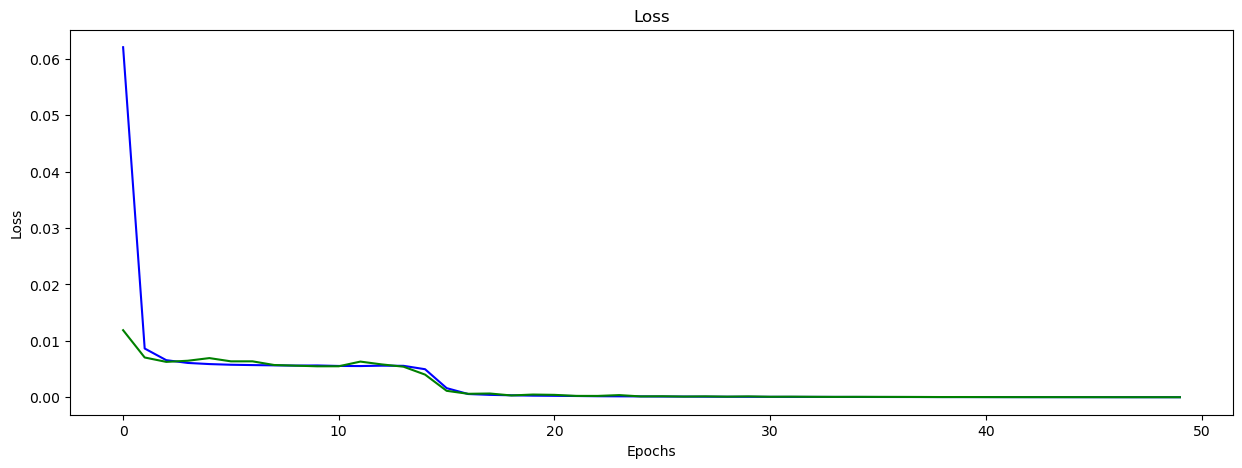

In [6]:


# optimizer = torch.optim.AdamW(model.parameters(), lr=1.5e-8, weight_decay=0.05)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50)

model.norm_pix_loss = False
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=0.05, betas=(0.9, 0.95))
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50)

total_epochs =50 
batches_per_epoch = len(TrainLoader)
total_training_steps = total_epochs * batches_per_epoch
num_warmup_steps = int(total_training_steps * 0.4)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps, total_training_steps)

Train_MAE(model, TrainLoader, ValidationLoader, optimizer,
            epochs=total_epochs, device='mps', scheduler=scheduler, masking_ratio=0.2)

100%|██████████| 24/24 [00:09<00:00,  2.46it/s]



Epoch 1/50 -
	Training Loss: 5.470202174470055e-05
	Val Loss: 5.5719298416079255e-05 



100%|██████████| 24/24 [00:09<00:00,  2.51it/s]



Epoch 6/50 -
	Training Loss: 7.31940258447139e-05
	Val Loss: 7.46386798103534e-05 



100%|██████████| 24/24 [00:09<00:00,  2.47it/s]



Epoch 11/50 -
	Training Loss: 9.488309269027713e-05
	Val Loss: 8.420801683920824e-05 



100%|██████████| 24/24 [00:09<00:00,  2.47it/s]



Epoch 16/50 -
	Training Loss: 0.00011279655032362476
	Val Loss: 0.00014681997254228918 



100%|██████████| 24/24 [00:10<00:00,  2.36it/s]



Epoch 21/50 -
	Training Loss: 0.00010655993964274575
	Val Loss: 0.000163892447744729 



100%|██████████| 24/24 [00:10<00:00,  2.34it/s]



Epoch 26/50 -
	Training Loss: 8.474391422798642e-05
	Val Loss: 0.00011113278408932577 



100%|██████████| 24/24 [00:10<00:00,  2.39it/s]



Epoch 31/50 -
	Training Loss: 5.5263767815351734e-05
	Val Loss: 6.511419026840788e-05 



100%|██████████| 24/24 [00:09<00:00,  2.51it/s]



Epoch 36/50 -
	Training Loss: 4.152523711826898e-05
	Val Loss: 5.792945800446129e-05 



100%|██████████| 24/24 [00:09<00:00,  2.51it/s]



Epoch 41/50 -
	Training Loss: 2.8727260463221264e-05
	Val Loss: 3.382885309595925e-05 



100%|██████████| 24/24 [00:09<00:00,  2.51it/s]



Epoch 46/50 -
	Training Loss: 1.9806435598359083e-05
	Val Loss: 1.761372370386501e-05 



100%|██████████| 24/24 [00:09<00:00,  2.51it/s]

Final Performance:
	Training Loss: 6.477818902121377e-05
	Test Loss: 7.665839493824932e-05
Finished Training


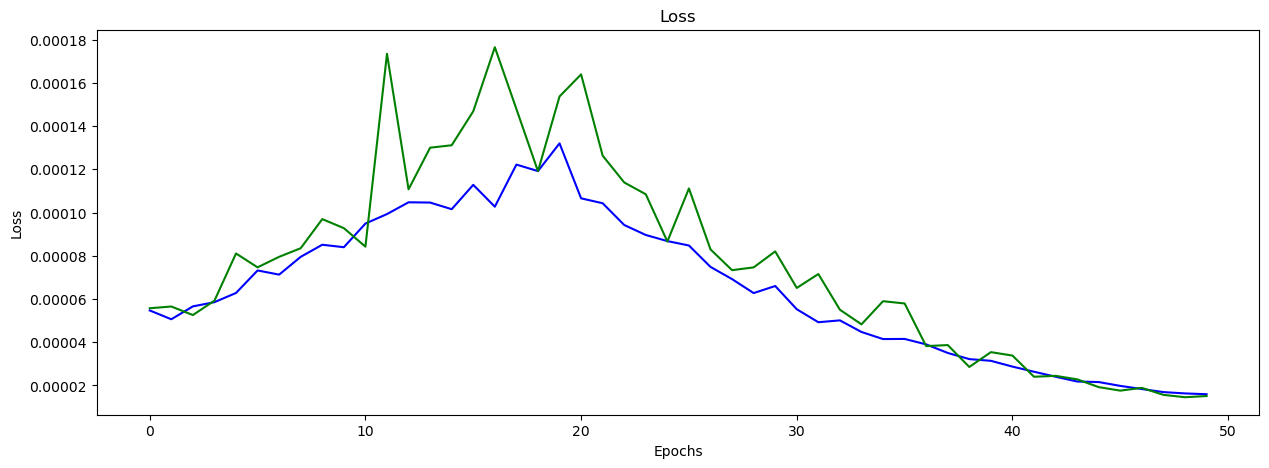

In [7]:
total_epochs =50 
batches_per_epoch = len(TrainLoader)
total_training_steps = total_epochs * batches_per_epoch
num_warmup_steps = int(total_training_steps * 0.4)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps, total_training_steps)

Train_MAE(model, TrainLoader, ValidationLoader, optimizer,
            epochs=total_epochs, device='mps', scheduler=scheduler, masking_ratio=0.4)

100%|██████████| 24/24 [00:07<00:00,  3.09it/s]



Epoch 1/50 -
	Training Loss: 8.636646529899175e-05
	Val Loss: 7.684642393238998e-05 



100%|██████████| 24/24 [00:07<00:00,  3.13it/s]



Epoch 6/50 -
	Training Loss: 9.651921511879034e-05
	Val Loss: 0.00010020918216468999 



100%|██████████| 24/24 [00:07<00:00,  3.14it/s]



Epoch 11/50 -
	Training Loss: 0.00013499033995965595
	Val Loss: 0.0001569356894227288 



100%|██████████| 24/24 [00:07<00:00,  3.12it/s]



Epoch 16/50 -
	Training Loss: 0.00016599254880790025
	Val Loss: 0.00015857745772033618 



100%|██████████| 24/24 [00:07<00:00,  3.14it/s]



Epoch 21/50 -
	Training Loss: 0.00016288218396836711
	Val Loss: 0.0001512392912748813 



100%|██████████| 24/24 [00:07<00:00,  3.12it/s]



Epoch 26/50 -
	Training Loss: 0.00010707141028923125
	Val Loss: 0.0001317594108816896 



100%|██████████| 24/24 [00:07<00:00,  3.13it/s]



Epoch 31/50 -
	Training Loss: 8.803221306572176e-05
	Val Loss: 9.861552128616798e-05 



100%|██████████| 24/24 [00:07<00:00,  3.13it/s]



Epoch 36/50 -
	Training Loss: 7.187721037273429e-05
	Val Loss: 6.847538194657925e-05 



100%|██████████| 24/24 [00:07<00:00,  3.14it/s]



Epoch 41/50 -
	Training Loss: 5.036195167261982e-05
	Val Loss: 5.386737924103121e-05 



100%|██████████| 24/24 [00:07<00:00,  3.13it/s]



Epoch 46/50 -
	Training Loss: 3.4117665651277864e-05
	Val Loss: 3.6831409261139925e-05 



100%|██████████| 24/24 [00:07<00:00,  3.13it/s]

Final Performance:
	Training Loss: 9.724166763117655e-05
	Test Loss: 0.00010818174410057207
Finished Training


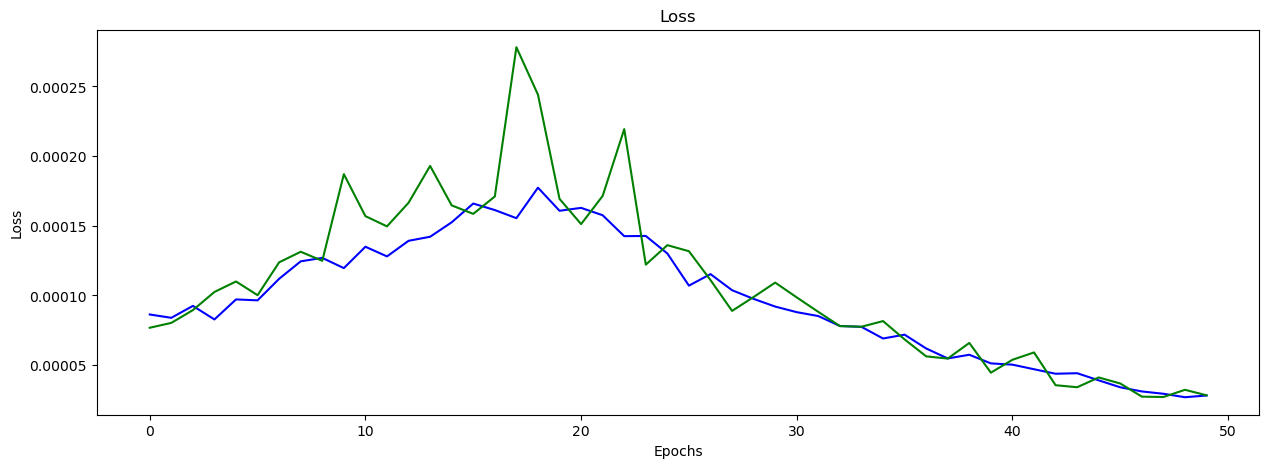

In [8]:
total_epochs = 50 
batches_per_epoch = len(TrainLoader)
total_training_steps = total_epochs * batches_per_epoch
num_warmup_steps = int(total_training_steps * 0.4)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps, total_training_steps)

Train_MAE(model, TrainLoader, ValidationLoader, optimizer,
            epochs=total_epochs, device='mps', scheduler=scheduler, masking_ratio=0.6)

100%|██████████| 24/24 [00:05<00:00,  4.19it/s]



Epoch 1/50 -
	Training Loss: 0.0004075282696738633
	Val Loss: 0.0003705828670111562 



100%|██████████| 24/24 [00:05<00:00,  4.16it/s]



Epoch 6/50 -
	Training Loss: 0.0003687153303662154
	Val Loss: 0.0003671189888336812 



100%|██████████| 24/24 [00:05<00:00,  4.21it/s]



Epoch 11/50 -
	Training Loss: 0.0004114636458325549
	Val Loss: 0.00040446172291315935 



100%|██████████| 24/24 [00:05<00:00,  4.20it/s]



Epoch 16/50 -
	Training Loss: 0.00044730547324434156
	Val Loss: 0.0004339934178763845 



100%|██████████| 24/24 [00:05<00:00,  4.18it/s]



Epoch 21/50 -
	Training Loss: 0.00045336432126182795
	Val Loss: 0.00045098188032473746 



100%|██████████| 24/24 [00:05<00:00,  4.19it/s]



Epoch 26/50 -
	Training Loss: 0.0003833998758776803
	Val Loss: 0.0004013897456995134 



100%|██████████| 24/24 [00:05<00:00,  4.19it/s]



Epoch 31/50 -
	Training Loss: 0.00029818590215095005
	Val Loss: 0.0003059094791145374 



100%|██████████| 24/24 [00:05<00:00,  4.16it/s]



Epoch 36/50 -
	Training Loss: 0.0002233331883522064
	Val Loss: 0.0002205180959814849 



100%|██████████| 24/24 [00:05<00:00,  4.19it/s]



Epoch 41/50 -
	Training Loss: 0.0001870704810384128
	Val Loss: 0.00019641374213582216 



100%|██████████| 24/24 [00:05<00:00,  4.18it/s]



Epoch 46/50 -
	Training Loss: 0.00013268968480308383
	Val Loss: 0.00011377918034819838 



100%|██████████| 24/24 [00:05<00:00,  4.19it/s]

Final Performance:
	Training Loss: 0.0003149779595378277
	Test Loss: 0.0003170423459452346
Finished Training


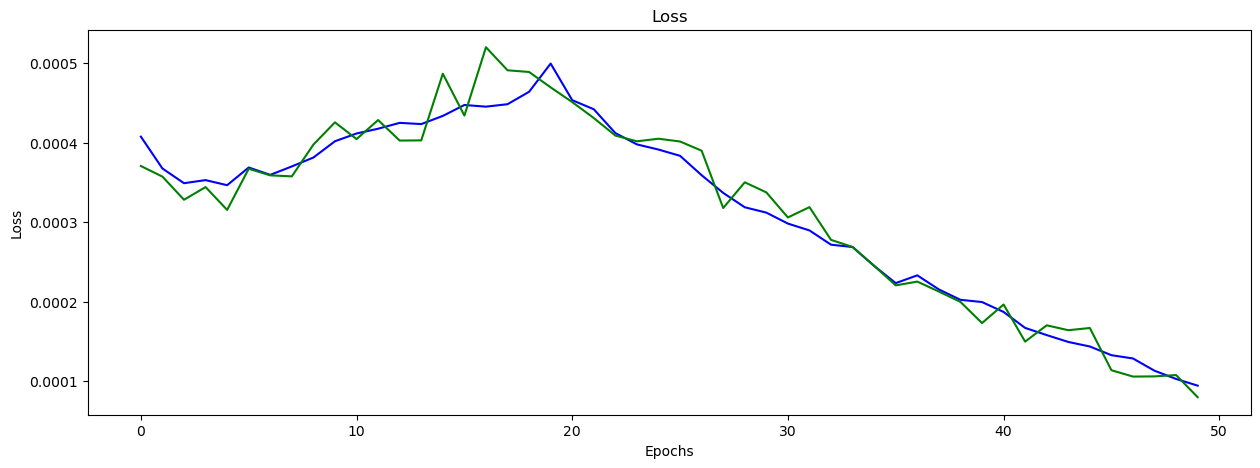

In [9]:
total_epochs = 50 
batches_per_epoch = len(TrainLoader)
total_training_steps = total_epochs * batches_per_epoch
num_warmup_steps = int(total_training_steps * 0.4)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps, total_training_steps)

Train_MAE(model, TrainLoader, ValidationLoader, optimizer,
            epochs=total_epochs, device='mps', scheduler=scheduler, masking_ratio=0.8)

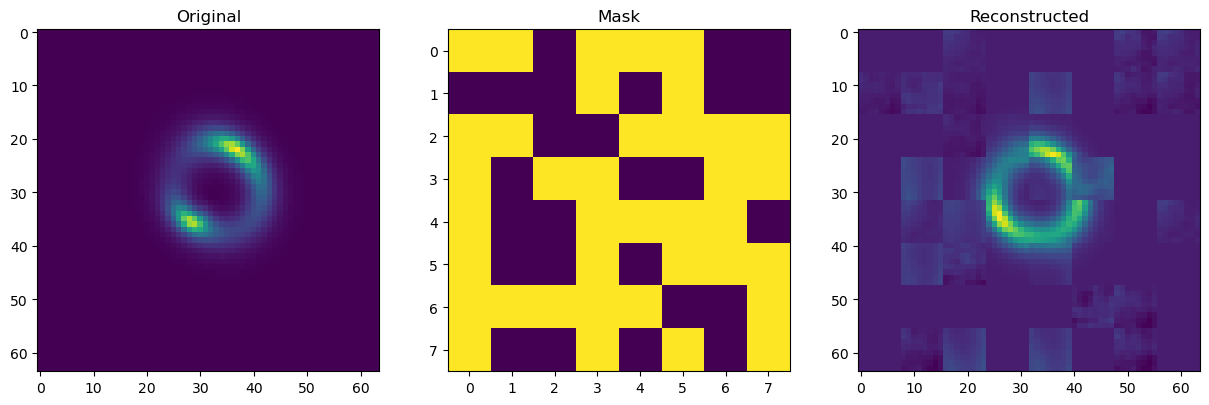

In [58]:
device = 'mps' if torch.backends.mps.is_available() else 'cpu'
visualize_reconstruction(model, Data, index=0, mask_ratio=0.6, patch_size=8, device=device)

In [30]:
torch.save(model.state_dict(), '../ModelWeights/MaskedAutoEncoder__Very_VeryDeep_Final__Solution.pth')

In [12]:
device = 'mps' if torch.backends.mps.is_available() else 'cpu'
model.to(device)
image = Data[4].unsqueeze(0).to(device)  # (1, 1, 64, 64)
latent, _, _ = model.forward_encoder(image, masking_ratio=0.75)
print(latent.shape)  # Should be (1, 4, 768) - 4 unmasked patches
print(latent.var(dim=1).mean())  # Variance across patches

torch.Size([1, 16, 768])
tensor(86.5186, device='mps:0', grad_fn=<MeanBackward0>)


In [13]:
print("Decoder Positional Embeddings Variance:", model.decoder_pos_embed.var(dim=1).mean().item())

Decoder Positional Embeddings Variance: 0.04467843472957611


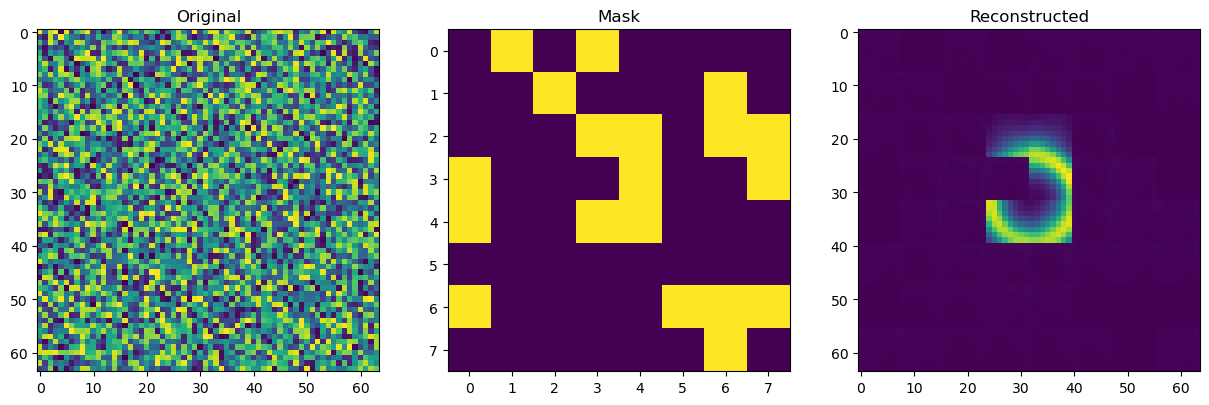

In [29]:
TestingData = torch.rand(4, 1, 64, 64).to(device)
visualize_reconstruction(model, TestingData, index=2, mask_ratio=0.3, patch_size=8, device=device)